In [3]:
import pandas as pd
import numpy as np


#Load data
data_training=pd.read_csv('census-income-training.csv',header=0)

#Clean data
#replace invalid or missing entries(delete individual row)
data_training_clean=data_training.replace(regex=[r'\?'],value=np.nan)
data_training=data_training_clean.dropna(how='any')


# Split the data into features and target label
income_raw = data_training['income_morethan_50K']
features_raw = data_training.drop(['income_morethan_50K','Id','GRINREG','MIGMTR1','MIGMTR3','MIGSAME','PARENT','PEFNTVTY','PEMNTVTY','PENATVTY'],axis=1)


# Visualize skewed continuous features of original data
#vs.distribution(data)

# Log-transform the skewed features
skewed = ['AHRSPAY','CAPGAIN', 'CAPLOSS','DIVVAL']
features_log_transformed = pd.DataFrame(features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

#Normalizing Numerical Features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['AAGE', 'ADTOCC', 'AHRSPAY', 'CAPGAIN','CAPLOSS', 'DIVVAL','HHDREL','NOEMP']
features_log_minmax_transform = pd.DataFrame(features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Data Preprocessing: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)
income_final= income_raw

# Print the number of features after one-hot encoding
#encoded = list(features_final.columns)
#print ' total features after one-hot encoding.'
#display (encoded)

#Split the Data into Training and Test Sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_final,income_final,test_size = 0.2,random_state = 0)


In [4]:
#Xgboost
from xgboost import XGBClassifier
#View default Values

xgbc=XGBClassifier()
xgbc.fit(x_train,y_train)
print(xgbc)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:11:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [6]:
#default
xgbc=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


xgbc.fit(x_train,y_train)
xgbc_y_predict=xgbc.predict(x_test)
xgbc.score(x_test,y_test)
print('score of XGBoost')
print(xgbc.score(x_test,y_test))

#Accuracy of prediction
from sklearn.metrics import classification_report
print('Prediction accuracy of XGBoost')
print(classification_report(y_test,xgbc_y_predict))

[07:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score of XGBoost
0.9459298871063577
Prediction accuracy of XGBoost
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12434
           1       0.73      0.46      0.57      1030

    accuracy                           0.95     13464
   macro avg       0.84      0.72      0.77     13464
weighted avg       0.94      0.95      0.94     13464



In [7]:
#max_depth 和min_child_weight
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier

                        (base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), 
                        
              param_grid = param_test1, scoring='roc_auc',n_jobs=4,refit=False, cv=5)

gsearch1.fit(x_train,y_train)
means = gsearch1.cv_results_['mean_test_score']
params = gsearch1.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))


0.930947  with:   {'max_depth': 3, 'min_child_weight': 1}
0.931198  with:   {'max_depth': 3, 'min_child_weight': 3}
0.931172  with:   {'max_depth': 3, 'min_child_weight': 5}
0.930276  with:   {'max_depth': 5, 'min_child_weight': 1}
0.930726  with:   {'max_depth': 5, 'min_child_weight': 3}
0.930626  with:   {'max_depth': 5, 'min_child_weight': 5}
0.928978  with:   {'max_depth': 7, 'min_child_weight': 1}
0.929041  with:   {'max_depth': 7, 'min_child_weight': 3}
0.928360  with:   {'max_depth': 7, 'min_child_weight': 5}
0.926721  with:   {'max_depth': 9, 'min_child_weight': 1}
0.926029  with:   {'max_depth': 9, 'min_child_weight': 3}
0.925406  with:   {'max_depth': 9, 'min_child_weight': 5}


In [13]:
#max_depth 和min_child_weight again
param_test2 = {
 'max_depth':list(range(2,5,1)),
 'min_child_weight':list(range(2,6,1))
}
gsearch2 = GridSearchCV(estimator = XGBClassifier

                        (base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), 
                        
              param_grid = param_test2, scoring='roc_auc',n_jobs=4,refit=False, cv=5)
                        
gsearch2.fit(x_train,y_train)
means = gsearch2.cv_results_['mean_test_score']
params = gsearch2.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

0.928396  with:   {'max_depth': 2, 'min_child_weight': 2}
0.928569  with:   {'max_depth': 2, 'min_child_weight': 3}
0.928668  with:   {'max_depth': 2, 'min_child_weight': 4}
0.928699  with:   {'max_depth': 2, 'min_child_weight': 5}
0.930947  with:   {'max_depth': 3, 'min_child_weight': 2}
0.931198  with:   {'max_depth': 3, 'min_child_weight': 3}
0.931257  with:   {'max_depth': 3, 'min_child_weight': 4}
0.931172  with:   {'max_depth': 3, 'min_child_weight': 5}
0.931907  with:   {'max_depth': 4, 'min_child_weight': 2}
0.932053  with:   {'max_depth': 4, 'min_child_weight': 3}
0.931353  with:   {'max_depth': 4, 'min_child_weight': 4}
0.931470  with:   {'max_depth': 4, 'min_child_weight': 5}


In [14]:
#gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,6)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier

                        (base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=3,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), 
                        
              param_grid = param_test3, scoring='roc_auc',n_jobs=4,refit=False, cv=5)

gsearch3.fit(x_train,y_train)
means = gsearch3.cv_results_['mean_test_score']
params = gsearch3.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

0.932053  with:   {'gamma': 0.0}
0.931983  with:   {'gamma': 0.1}
0.931987  with:   {'gamma': 0.2}
0.931836  with:   {'gamma': 0.3}
0.931628  with:   {'gamma': 0.4}
0.931707  with:   {'gamma': 0.5}


In [17]:
#subsample,colsample_bytree
param_test4 = {
 'subsample':[i/100.0 for i in range(75,100,5)],
 'colsample_bytree':[i/100.0 for i in range(75,100,5)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier

                        (base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=3,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None), 
                        
              param_grid = param_test4, scoring='roc_auc',n_jobs=4,refit=False, cv=5)

gsearch4.fit(x_train,y_train)
means = gsearch4.cv_results_['mean_test_score']
params = gsearch4.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

0.930487  with:   {'colsample_bytree': 0.75, 'subsample': 0.75}
0.930957  with:   {'colsample_bytree': 0.75, 'subsample': 0.8}
0.930915  with:   {'colsample_bytree': 0.75, 'subsample': 0.85}
0.931266  with:   {'colsample_bytree': 0.75, 'subsample': 0.9}
0.931704  with:   {'colsample_bytree': 0.75, 'subsample': 0.95}
0.930377  with:   {'colsample_bytree': 0.8, 'subsample': 0.75}
0.931061  with:   {'colsample_bytree': 0.8, 'subsample': 0.8}
0.931731  with:   {'colsample_bytree': 0.8, 'subsample': 0.85}
0.931650  with:   {'colsample_bytree': 0.8, 'subsample': 0.9}
0.931420  with:   {'colsample_bytree': 0.8, 'subsample': 0.95}
0.931023  with:   {'colsample_bytree': 0.85, 'subsample': 0.75}
0.931291  with:   {'colsample_bytree': 0.85, 'subsample': 0.8}
0.931208  with:   {'colsample_bytree': 0.85, 'subsample': 0.85}
0.931608  with:   {'colsample_bytree': 0.85, 'subsample': 0.9}
0.931114  with:   {'colsample_bytree': 0.85, 'subsample': 0.95}
0.930308  with:   {'colsample_bytree': 0.9, 'subsam

In [19]:
#Xgboost,After the adjustment
from xgboost import XGBClassifier


xgbc=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=3,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

xgbc.fit(x_train,y_train)
xgbc_y_predict=xgbc.predict(x_test)
xgbc.score(x_test,y_test)
print('score of XGBoost')
print(xgbc.score(x_test,y_test))

#Accuracy of prediction
from sklearn.metrics import classification_report
print('Prediction accuracy of XGBoost')
print(classification_report(y_test,xgbc_y_predict))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score of XGBoost
0.946078431372549
Prediction accuracy of XGBoost
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12434
           1       0.73      0.46      0.57      1030

    accuracy                           0.95     13464
   macro avg       0.85      0.72      0.77     13464
weighted avg       0.94      0.95      0.94     13464



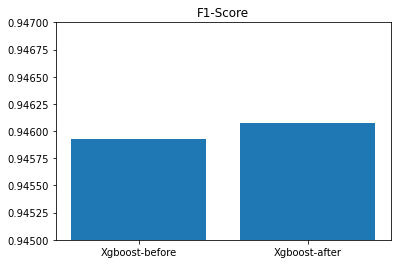

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

num_list_score =[0.9459298871063577,0.946078431372549]
name_list_score=['Xgboost-before','Xgboost-after']
plt.bar(range(len(num_list_score)),num_list_score,tick_label=name_list_score)
plt.title('F1-Score')
plt.ylim(0.945,0.947)
plt.show() 